In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pickle
import string
import requests
import collections
import io
import tarfile
import urllib.request
import text_helpers
from nltk.corpus import stopwords
from tensorflow.python.framework import ops
ops.reset_default_graph()

sess = tf.Session()

In [2]:
embedding_size = 200  # このサイズを変更するときは、05_Working_With_CBOWの埋め込みサイズも変更し、再度実行してこと！
vocabulary_size = 2000
batch_size = 100
max_words = 100

# ストップワードを設定
stops = stopwords.words('english')

In [3]:
# データをロード
texts, target = text_helpers.load_movie_data()

# テキストを正規化
texts = text_helpers.normalize_text(texts, stops)

# テキストには少なくとも3つの単語が含まれていなければならない。
target = [target[ix] for ix, x in enumerate(texts) if len(x.split()) > 2]
texts = [x for x in texts if len(x.split()) > 2]

# データセットをトレーニングセットとテストセットに分割
train_indices = np.random.choice(len(target), round(0.8*len(target)), replace=False)
test_indices = np.array(list(set(range(len(target))) - set(train_indices)))
texts_train = [x for ix, x in enumerate(texts) if ix in train_indices]
texts_test = [x for ix, x in enumerate(texts) if ix in test_indices]
target_train = np.array([x for ix, x in enumerate(target) if ix in train_indices])
target_test = np.array([x for ix, x in enumerate(target) if ix in test_indices])

Loading Data
Normalizing Text Data
Done.


In [4]:
dict_file = os.path.join( '.', 'temp', 'movie_vocab.pkl')
word_dictionary = pickle.load(open(dict_file, 'rb'))

In [5]:
text_data_train = np.array(text_helpers.text_to_numbers(texts_train, word_dictionary))
text_data_test = np.array(text_helpers.text_to_numbers(texts_test, word_dictionary))

In [6]:
text_data_train = np.array([x[0:max_words] for x in [y+[0]*max_words for y in text_data_train]])
text_data_test = np.array([x[0:max_words] for x in [y+[0]*max_words for y in text_data_test]])

In [7]:
# ロジスティック回帰の変数を作成
A = tf.Variable(tf.random_normal(shape=[embedding_size,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

# プレースホルダを初期化
x_data = tf.placeholder(shape=[None, max_words], dtype=tf.int32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

Creating Model


In [8]:
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))

In [9]:
# 埋め込みベクトルを検索
embed = tf.nn.embedding_lookup(embeddings, x_data)
# 文書内のすべての単語埋め込みの平均
embed_avg = tf.reduce_mean(embed, 1)

In [10]:
# ロジスティックモデルを設定
model_output = tf.add(tf.matmul(embed_avg, A), b)

# 損失関数（交差エントロピー）を設定
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_output, labels=y_target))

Done.


In [11]:
prediction = tf.round(tf.sigmoid(model_output))
predictions_correct = tf.cast(tf.equal(prediction, y_target), tf.float32)
accuracy = tf.reduce_mean(predictions_correct)

In [12]:
my_opt = tf.train.AdagradOptimizer(0.005)
train_step = my_opt.minimize(loss)

init = tf.global_variables_initializer()
sess.run(init)

In [15]:
model_checkpoint_path = os.path.join( '.', 'temp','cbow_movie_embeddings.ckpt')
saver = tf.train.Saver({"embeddings": embeddings})
saver.restore(sess, model_checkpoint_path)

INFO:tensorflow:Restoring parameters from ./temp/cbow_movie_embeddings.ckpt


In [16]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []
i_data = []
for i in range(10000):
    rand_index = np.random.choice(text_data_train.shape[0], size=batch_size)
    rand_x = text_data_train[rand_index]
    rand_y = np.transpose([target_train[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    
    # 損失値と正解率を100回おきに記録
    if (i+1)%100==0:
        i_data.append(i+1)
        train_loss_temp = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
        train_loss.append(train_loss_temp)
        
        test_loss_temp = sess.run(loss, feed_dict={x_data: text_data_test, y_target: np.transpose([target_test])})
        test_loss.append(test_loss_temp)
        
        train_acc_temp = sess.run(accuracy, feed_dict={x_data: rand_x, y_target: rand_y})
        train_acc.append(train_acc_temp)
    
        test_acc_temp = sess.run(accuracy, feed_dict={x_data: text_data_test, y_target: np.transpose([target_test])})
        test_acc.append(test_acc_temp)
    if (i+1)%500==0:
        acc_and_loss = [i+1, train_loss_temp, test_loss_temp, train_acc_temp, test_acc_temp]
        acc_and_loss = [np.round(x,2) for x in acc_and_loss]
        print('Generation # {}. Train Loss (Test Loss): {:.2f} ({:.2f}). Train Acc (Test Acc): {:.2f} ({:.2f})'.format(*acc_and_loss))

Starting Model Training
Generation # 500. Train Loss (Test Loss): 0.71 (0.70). Train Acc (Test Acc): 0.52 (0.50)
Generation # 1000. Train Loss (Test Loss): 0.69 (0.70). Train Acc (Test Acc): 0.55 (0.50)
Generation # 1500. Train Loss (Test Loss): 0.70 (0.70). Train Acc (Test Acc): 0.53 (0.51)
Generation # 2000. Train Loss (Test Loss): 0.69 (0.70). Train Acc (Test Acc): 0.58 (0.51)
Generation # 2500. Train Loss (Test Loss): 0.70 (0.70). Train Acc (Test Acc): 0.49 (0.50)
Generation # 3000. Train Loss (Test Loss): 0.70 (0.70). Train Acc (Test Acc): 0.52 (0.51)
Generation # 3500. Train Loss (Test Loss): 0.71 (0.70). Train Acc (Test Acc): 0.50 (0.50)
Generation # 4000. Train Loss (Test Loss): 0.69 (0.70). Train Acc (Test Acc): 0.50 (0.51)
Generation # 4500. Train Loss (Test Loss): 0.69 (0.70). Train Acc (Test Acc): 0.57 (0.51)
Generation # 5000. Train Loss (Test Loss): 0.69 (0.70). Train Acc (Test Acc): 0.52 (0.52)
Generation # 5500. Train Loss (Test Loss): 0.70 (0.70). Train Acc (Test Acc):

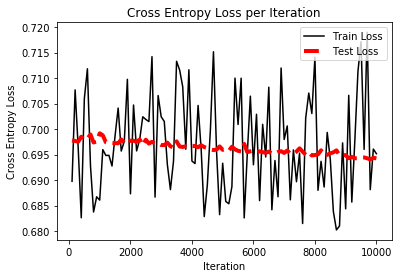

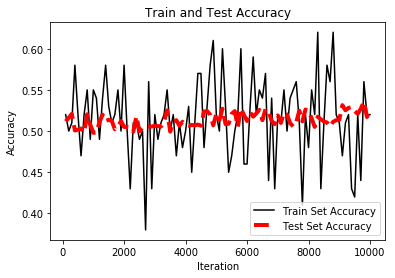

In [17]:
# 損失値をプロット
plt.plot(i_data, train_loss, 'k-', label='Train Loss')
plt.plot(i_data, test_loss, 'r--', label='Test Loss', linewidth=4)
plt.title('Cross Entropy Loss per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Cross Entropy Loss')
plt.legend(loc='upper right')
plt.show()

# 正解率をプロット
plt.plot(i_data, train_acc, 'k-', label='Train Set Accuracy')
plt.plot(i_data, test_acc, 'r--', label='Test Set Accuracy', linewidth=4)
plt.title('Train and Test Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()
